# Watts-Strogatz

In this notebook we compute the minimal and loose homological scaffolds of a Watts-Strogatz (weighted) random graph. We follow the framework of (__[Sizemore, Giusti, Bassett: Classification of weighted networks through mesoscale homological features. Journal of Complex Network (2017)](https://doi.org/10.1093/comnet/cnw013)__)

Libraries

In [1]:
# source files are two folders above
import sys
sys.path.append('../../src')

import Driver
import Geometry
import Scaffold

import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pk

sys.path.append('../../')
import Holes as ho

Set the parameters for the Watts-Strogatz model (__[ref](https://doi.org/10.1093/comnet/cnw013)__). To build a weighted Watts-Strogatz random graph, we follow the approach in the paper, illustrated __[here](https://sites.google.com/a/seas.upenn.edu/weighted-network-toolbox/network-construction)__. <br>
As per the choice of parameters, the paper uses $83$ nodes, with a stub count of $50$, and a rewiring probability of $0,025$. We have repeated the analysis with several different combinations, the choice below being made for speed of visualization.

In [4]:
# Set the parameters
NV = 50
k = 20
p = 0.025

# Create the ring lattice
A = np.zeros( (NV,NV))
for i in range(NV):
    for j in range(k//2):
        j+=1
        tj = (i+j)%NV
        d = min(j, np.abs(i-tj))
        A[i , tj] = 1/d if d!=0 else 0


#np.reciprocal(A,out=A,where=A[A!=0])
A = 0.5*(A + A.transpose())

# Now rewire
def pick_new(row,i):
    zr = np.nonzero(row == 0)
    zr = zr[0]
    zr = np.setdiff1d(zr,np.array(i))
    if len(zr) == 0:
        raise ValueError
    ind = np.random.choice(zr)
    return ind

for i in range(NV):
    for j in range(i,NV):
        if (A[i,j] != 0 and np.random.random() < p ):
            try:
                node = pick_new(A[i,:],i)              
                A[i,node] = A[i,j]
                A[node,i] = A[i,j]
                A[i,j] = 0
                A[j,i] = 0
            except:
                pass

From the adjacency matrix build the graph, and draw it.

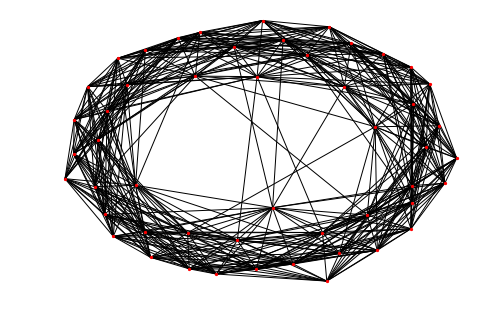

In [5]:
G = nx.from_numpy_matrix(A,parallel_edges=False)
layout = nx.layout.spring_layout(G)
nx.draw(G, pos=layout, node_size=5)

### Loose Scaffold
Set up the paths

In [ ]:
import os, sys

basedir = '/Users/marco/Desktop/PhD/SHB/scaffold/scaffold/'
scriptdir = basedir + 'scripts/WS/'